# Planet Prediction
## Exploratory Data Analysis Notebook

In [158]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy import linspace

In [159]:
# Load Dataset
raw_data = ascii.read('../data/raw/plti/kplr_dr25_inj1_plti.txt')
df = raw_data.to_pandas()

df.head()

/Users/yutarochan/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'Fit_Provenance' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


,KIC_ID,Sky_Group,i_period,i_epoch,N_Transit,i_depth,i_dur,i_b,i_ror,i_dor,...,TCE_ID,Measured_MES,r_period,r_epoch,r_depth,r_dur,r_b,r_ror,r_dor,Fit_Provenance
0,11445144,8,70.0385,107.4886,0.9808,1662.0,4.02030,0.4141,0.0306,126.498,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11496840,8,87.8829,103.9753,0.9808,1561.0,2.20705,0.7649,0.0350,214.397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11497236,8,88.3020,84.4552,0.9808,1332.0,2.11234,0.8100,0.0334,207.336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11548779,8,35.4942,73.9562,2.9425,686.0,1.00655,0.8915,0.0247,138.661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11600744,8,48.8212,97.2396,23.2943,372.0,1.77915,0.8738,0.0183,110.768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### NaN Count

In [161]:
df.isna().sum()

KIC_ID                     0
Sky_Group                  0
i_period                   0
i_epoch                    0
N_Transit                  0
i_depth                    0
i_dur                      0
i_b                        0
i_ror                      0
i_dor                      0
EB_injection               0
Offset_from_source         0
Offset_distance            0
Expected_MES              37
Recovered                  0
TCE_ID                100917
Measured_MES          100917
r_period              100917
r_epoch               100917
r_depth               100917
r_dur                 100917
r_b                   100917
r_ror                 100917
r_dor                 100917
Fit_Provenance        100917
dtype: int64

## Independent Variable Analysis
We preform a simple analysis of each feature in the dataset. Specifically we look at all distributions and simple statistics of the dataset

### Sky Group
Sky group of the target star (identifies the target location by CCD
channel for season 2 as described in Appendix D, Thompson et al. 2016b)

In [162]:
df['Sky_Group'].describe()

count    146294.000000
mean         45.655775
std          23.880388
min           1.000000
25%          27.000000
50%          45.000000
75%          66.000000
max          84.000000
Name: Sky_Group, dtype: float64

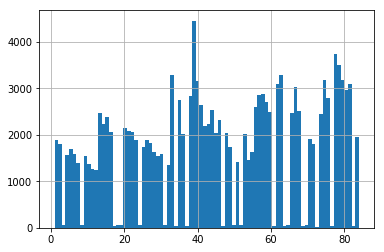

In [163]:
# Plot Distribution of Sky Group
df['Sky_Group'].hist(bins=84)
plt.show()

#### Sky Group Binning
Based on the distribution plotted above, we see that the Sky_Group has too many features and thus also leads to an irrelevant feature based on many of the feature analysis. Thus, we employ a binning method to reduce the size of the feature ranges.

For this, we use a data-driven method, the Shimazaki-Shinomoto Method to help find the optimal bin sizes for our data.

```
@inproceedings{shimazaki2007recipe,
  title={A recipe for optimizing a time-histogram},
  author={Shimazaki, Hideaki and Shinomoto, Shigeru},
  booktitle={Advances in neural information processing systems},
  pages={1289--1296},
  year={2007}
}
```

We use an implementation borrowed from: https://github.com/oldmonkABA/optimal_histogram_bin_width

In [87]:
def shimashino_bin(X, n_min, n_max, n_ideal):
    data_max = np.max(X)
    data_min = np.min(X)
    N = np.array(range(n_min, n_max))
    D = float(data_max - data_min) / N  # Bin Width Vector
    Cs = np.zeros((len(D), n_ideal))
    
    # Compute Cost Function
    for i in range(np.size(N)):
        shift = linspace(0, D[i], n_ideal)
        
        for j in range(n_ideal):
            edges = linspace(data_min + shift[j] - D[i] / 2, data_max + shift[j] - D[i] / 2, N[i] + 1) # Shift Bin Edges
            binindex = np.digitize(X, edges) # Find binindex of each data point
            ki = np.bincount(binindex)[1:N[i] + 1] # Find number of points in each bin
            k = np.mean(ki) # Mean of event count
            v = sum((ki-k)**2)/N[i] # Variance of event count
            Cs[i,j]+= (2*k-v)/((D[i])**2) # The cost Function
    C = Cs.mean(1)
    
    loc = np.argwhere(Cs==Cs.min())[0]
    cmin = C.min()
    idx  = np.where(C==cmin)
    idx = idx[0][0]
    optD = D[idx]
    
    print('Optimal Bin Number :' + str(N[idx]))
    print('Optimal Bin Width :' + str(optD))

In [93]:
shimashino_bin(df['Sky_Group'].values, 5, 500, 30)

Optimal Bin Number :499
Optimal Bin Width :0.166332665331


Based on the analysis above, data driven feature binning does not seem to be an appropriate tool for this, hence, we look to another method of feature engineering using known heuristics of the CCD channel inputs. We demonstrate some of the heuristics that we presented below.

### CCD Channel Pooling Heuristic
We define a new feature grouping heuristic, which utilizes some of the physical intrastructure of the Kepler telescope CCD channels. This is inspired from the heuristics used in Convolutional Neural Networks, where we pool the data based on the spatial orientation of the sensors.

#### Pool by Center
The first method we propose, is through pooling of the data by the corresponding panel of the CCD channel, as demonstrated below.

![panel](http://archive.stsci.edu/kepler/manuals/archive_manual_files/image048.gif)

In [164]:
# Center Pool Mapping
# Note: Representation of the mapping is not exactly the same as above...
panel = 2
center_map = {}
for i in range(1, 85):
    center_map[i] = panel
    if i % 4 == 0: 
        if panel == 4 or panel == 20:
            panel += 2
        else:
            panel += 1

print(center_map)

{1: 2, 2: 2, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 4, 13: 6, 14: 6, 15: 6, 16: 6, 17: 7, 18: 7, 19: 7, 20: 7, 21: 8, 22: 8, 23: 8, 24: 8, 25: 9, 26: 9, 27: 9, 28: 9, 29: 10, 30: 10, 31: 10, 32: 10, 33: 11, 34: 11, 35: 11, 36: 11, 37: 12, 38: 12, 39: 12, 40: 12, 41: 13, 42: 13, 43: 13, 44: 13, 45: 14, 46: 14, 47: 14, 48: 14, 49: 15, 50: 15, 51: 15, 52: 15, 53: 16, 54: 16, 55: 16, 56: 16, 57: 17, 58: 17, 59: 17, 60: 17, 61: 18, 62: 18, 63: 18, 64: 18, 65: 19, 66: 19, 67: 19, 68: 19, 69: 20, 70: 20, 71: 20, 72: 20, 73: 22, 74: 22, 75: 22, 76: 22, 77: 23, 78: 23, 79: 23, 80: 23, 81: 24, 82: 24, 83: 24, 84: 24}


#### Pool  by Corner
The second feature we can consider is pooling by the touching corners of the square. Here we can identify four types of filters we can pool by:

```
 _ _
|_|_|
|_|_|
Type 1: Four corner
   _
 _|_|
|_|_|
Type 2: Three corner
 _
|_|
|_|
Type 3: Double corner
 _
|_|
Type 1: Single corner
```

Similar to how we have filters in a convolution operation, these act somewhat like pseudo-filters by which we pool the corners together. Below we devise a mapping correponding to the corners.

In [165]:
# Manually Define Index Pairs for All Combinations
single = [4, 11, 15, 32, 56, 71, 75, 84]
double = [(3,8), (7,12), (16,35), (31,52), (36,55), (51,72), (76,79), (80,83)]
triple = [(1,14,20), (10,28,29), (53,60,74), (68,70,81)]
quad = [(2,5,19,24), (6,9,23,25), (13,17,34,39), (18,21,38,43), (22,26,42,45), (27,30,48,49), (33,40,54,59), 
        (37,44,58,62), (41,46,61,66), (47,50,65,69), (57,63,73,78), (64,67,77,82)]

# Joint Type Mapping
join_type = {}
for i in single: join_type[i] = 1
for i in list(itertools.chain(*double)): join_type[i] = 2
for i in list(itertools.chain(*triple)): join_type[i] = 3
for i in list(itertools.chain(*quad)): join_type[i] = 4
    
# print(join_type)

# Corner Group Mapping
corner_map = {}
for i, x in enumerate(single + double + triple + quad):
    if isinstance(x, int): 
        corner_map[x] = i
    else:
        for j in x: corner_map[j] = i

print(corner_map)

{4: 0, 11: 1, 15: 2, 32: 3, 56: 4, 71: 5, 75: 6, 84: 7, 3: 8, 8: 8, 7: 9, 12: 9, 16: 10, 35: 10, 31: 11, 52: 11, 36: 12, 55: 12, 51: 13, 72: 13, 76: 14, 79: 14, 80: 15, 83: 15, 1: 16, 14: 16, 20: 16, 10: 17, 28: 17, 29: 17, 53: 18, 60: 18, 74: 18, 68: 19, 70: 19, 81: 19, 2: 20, 5: 20, 19: 20, 24: 20, 6: 21, 9: 21, 23: 21, 25: 21, 13: 22, 17: 22, 34: 22, 39: 22, 18: 23, 21: 23, 38: 23, 43: 23, 22: 24, 26: 24, 42: 24, 45: 24, 27: 25, 30: 25, 48: 25, 49: 25, 33: 26, 40: 26, 54: 26, 59: 26, 37: 27, 44: 27, 58: 27, 62: 27, 41: 28, 46: 28, 61: 28, 66: 28, 47: 29, 50: 29, 65: 29, 69: 29, 57: 30, 63: 30, 73: 30, 78: 30, 64: 31, 67: 31, 77: 31, 82: 31}


#### Channel Orientation
Another feature that we can consider is the feature orientaiton of the CCD channels for each of the panel. We believe that based on the orientation of the sensors, there may be some possible properties that may be extacted from the data. We correspondingly create a mapping for the orientation.

In [166]:
t_1 = [2, 3, 4, 7, 8]
t_2 = [6, 11, 12, 13, 16, 17]
t_3 = [9, 10, 14, 15, 20, 23]
t_4 = [18, 19, 22, 24]

ch_ori = {}
for t in t_1: ch_ori[t] = 1
for t in t_2: ch_ori[t] = 2
for t in t_3: ch_ori[t] = 3
for t in t_4: ch_ori[t] = 4
    
print(ch_ori)

{2: 1, 3: 1, 4: 1, 7: 1, 8: 1, 6: 2, 11: 2, 12: 2, 13: 2, 16: 2, 17: 2, 9: 3, 10: 3, 14: 3, 15: 3, 20: 3, 23: 3, 18: 4, 19: 4, 22: 4, 24: 4}


### Sky Group Visualization
To better visualize and characterize each of the feature's properties per CCD channel, we generate a plot similar to the one above.

In [167]:
# Orientation Tuple
def ori_tup(x, y, ori):
    if ori == 1: return [(x, y), (x+1, y), (x+1, y-1), (x, y-1)]
    elif ori == 2: return [(x, y), (x, y-1), (x-1, y-1), (x-1, y)]
    elif ori == 3: return [(x, y), (x, y+1), (x+1, y+1), (x+1, y)]
    elif ori == 4: return [(x, y), (x-1, y), (x-1, y+1), (x, y+1)]

# Generate Coordinate Map
st_cord = {1:(2,1), 5:(4,1), 9:(6,1), 13:(1,3), 17:(2,3), 21:(4,3),
          25:(6,2), 29:(8,2), 33:(1,5), 37:(3,5), 41:(5,5), 45:(6,4),
          49:(8,4), 53:(1,7), 57:(3,7), 61:(5,6), 65:(7,6), 69:(8,6),
          73:(3,8), 77:(5,8), 81:(7,8)}

cord_map = {}
for id in st_cord:
    panel = center_map[id]
    c = st_cord[id]
    for idx, x in enumerate(ori_tup(c[0], c[1], ch_ori[panel])):
        cord_map[id+idx] = x
print(cord_map)

{1: (2, 1), 2: (3, 1), 3: (3, 0), 4: (2, 0), 5: (4, 1), 6: (5, 1), 7: (5, 0), 8: (4, 0), 9: (6, 1), 10: (7, 1), 11: (7, 0), 12: (6, 0), 13: (1, 3), 14: (1, 2), 15: (0, 2), 16: (0, 3), 17: (2, 3), 18: (3, 3), 19: (3, 2), 20: (2, 2), 21: (4, 3), 22: (5, 3), 23: (5, 2), 24: (4, 2), 25: (6, 2), 26: (6, 3), 27: (7, 3), 28: (7, 2), 29: (8, 2), 30: (8, 3), 31: (9, 3), 32: (9, 2), 33: (1, 5), 34: (1, 4), 35: (0, 4), 36: (0, 5), 37: (3, 5), 38: (3, 4), 39: (2, 4), 40: (2, 5), 41: (5, 5), 42: (5, 4), 43: (4, 4), 44: (4, 5), 45: (6, 4), 46: (6, 5), 47: (7, 5), 48: (7, 4), 49: (8, 4), 50: (8, 5), 51: (9, 5), 52: (9, 4), 53: (1, 7), 54: (1, 6), 55: (0, 6), 56: (0, 7), 57: (3, 7), 58: (3, 6), 59: (2, 6), 60: (2, 7), 61: (5, 6), 62: (4, 6), 63: (4, 7), 64: (5, 7), 65: (7, 6), 66: (6, 6), 67: (6, 7), 68: (7, 7), 69: (8, 6), 70: (8, 7), 71: (9, 7), 72: (9, 6), 73: (3, 8), 74: (2, 8), 75: (2, 9), 76: (3, 9), 77: (5, 8), 78: (5, 9), 79: (6, 9), 80: (6, 8), 81: (7, 8), 82: (6, 8), 83: (6, 9), 84: (7, 9)}


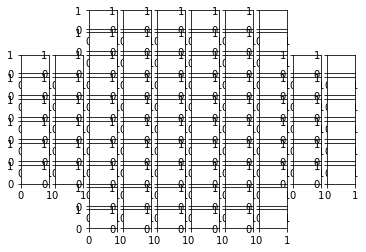

In [168]:
# Initialize Plot: Use the following structure to generate the CCD Plot
fig, axes = plt.subplots(10, 10)

# Remove Corner Plots
miss = [(0,0), (0,1), (1,0), (1,1), (0,8), (0,9), (1,8), (1,9), (8,0), (9,0), (8,1), (9,1), (8,8), (8,9), (9,8), (9,9)]
for m in miss: axes[m[0], m[1]].set_visible(False)

#### Per CCD Channel Data Count
In this section we look at the overall count of data per channel panels.

In [248]:
def ccd_matplot(param, title):
    rec_mat = [[0 for i in range(10)] for j in range(10)]

    for x in df[df[param] != 2].groupby(['Sky_Group']):
        c = cord_map[x[0]]
        rec_mat[c[0]][c[1]] = len(x[1])

    rec_mat = np.array(rec_mat)

    fig, ax = plt.subplots(figsize=(10,10))
    ax.matshow(np.array(rec_mat), cmap='viridis')

    for (i, j), z in np.ndenumerate(np.array(rec_mat)):
        ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center', fontsize=8, color='w')

    plt.title(title)
    plt.show()

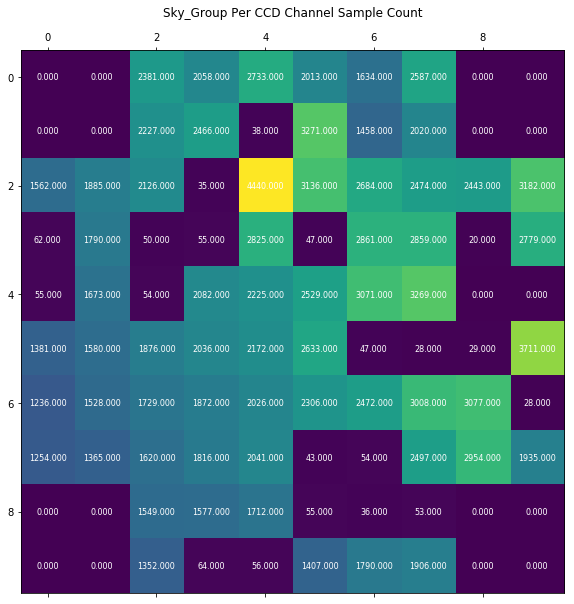

In [250]:
ccd_matplot('Recovered', 'Sky_Group Per CCD Channel Sample Count')

In [272]:
def ccd_hist(param, title):
    # Initialize Plot: Use the following structure to generate the CCD Plot
    fig, axes = plt.subplots(10, 10, figsize=(10,10))

    # Remove Corner Plots
    miss = [(0,0), (0,1), (1,0), (1,1), (0,8), (0,9), (1,8), (1,9), (8,0), (9,0), (8,1), (9,1), (8,8), (8,9), (9,8), (9,9)]
    for m in miss: axes[m[0], m[1]].set_visible(False)

    for x in df.groupby('Sky_Group'):
        c = cord_map[x[0]]
        axes[c[0]][c[1]].hist(x[1][param].dropna(), bins=30)
        axes[c[0]][c[1]].axes.get_xaxis().set_visible(False)
        axes[c[0]][c[1]].axes.get_yaxis().set_visible(False)

    plt.axis('off')
    plt.show()

In [256]:
def ccd_binhist(param, title):
    # Initialize Plot: Use the following structure to generate the CCD Plot
    fig, axes = plt.subplots(10, 10, figsize=(10,10))

    # Remove Corner Plots
    miss = [(0,0), (0,1), (1,0), (1,1), (0,8), (0,9), (1,8), (1,9), (8,0), (9,0), (8,1), (9,1), (8,8), (8,9), (9,8), (9,9)]
    for m in miss: axes[m[0], m[1]].set_visible(False)

    for x in df.groupby(['Sky_Group', 'Recovered']):
        c = cord_map[x[0][0]]
        if x[0][1] == 0:
            axes[c[0]][c[1]].hist(x[1][param].dropna(), bins=30)
        elif x[0][1] == 1:
            axes[c[0]][c[1]].hist(x[1][param].dropna(), bins=30)

        axes[c[0]][c[1]].axes.get_xaxis().set_visible(False)
        axes[c[0]][c[1]].axes.get_yaxis().set_visible(False)

    plt.axis('off')
    plt.show()

### Input Period
The orbital period (days) of the injected signal

In [6]:
df['i_period'].describe()

count    146294.000000
mean        240.811542
std         145.475269
min           0.502700
25%         111.653375
50%         237.599700
75%         365.994700
max         499.997600
Name: i_period, dtype: float64

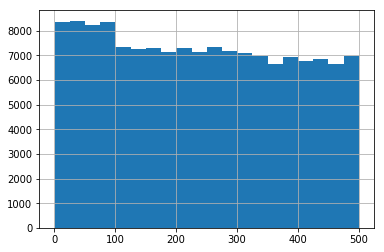

In [7]:
df['i_period'].hist(bins=20)
plt.show()

In [97]:
# Shima-Shiro Binning
shimashino_bin(df['i_period'].values, 1, 50, 30)

Optimal Bin Number :2
Optimal Bin Width :249.74745


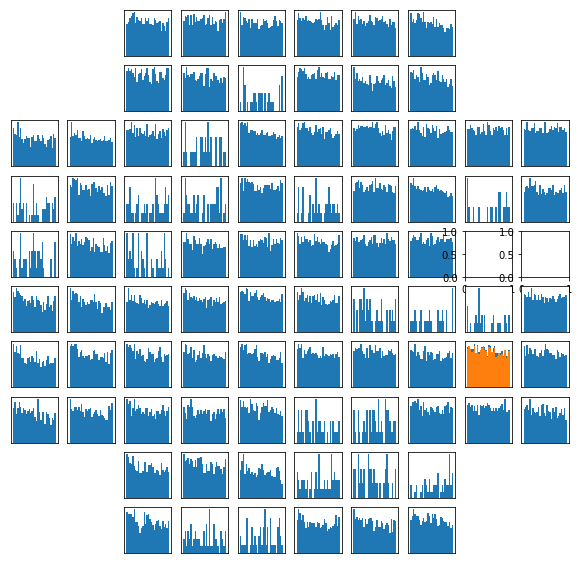

In [253]:
ccd_hist('i_period', 'i_Period')

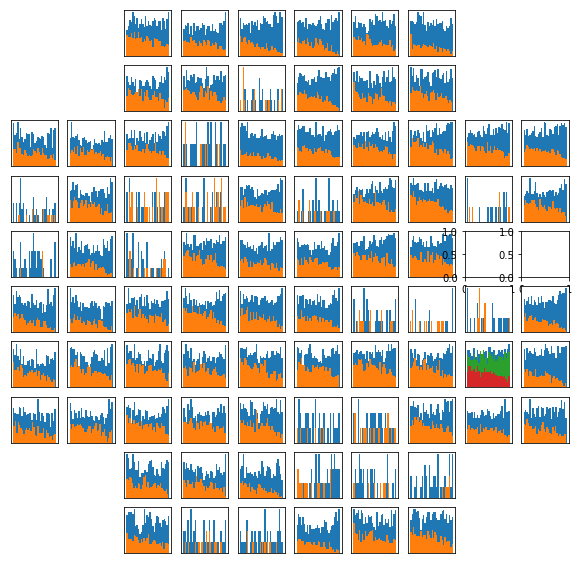

In [257]:
ccd_binhist('i_period', 'i_period')

### Input Epoch

In [8]:
df['i_epoch'].describe()

count    146294.000000
mean        185.547511
std         108.868803
min          64.998300
25%          95.959525
50%         153.055200
75%         249.615575
max         564.521100
Name: i_epoch, dtype: float64

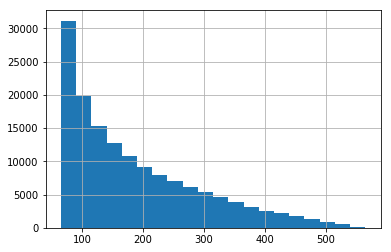

In [9]:
df['i_epoch'].hist(bins=20)
plt.show()

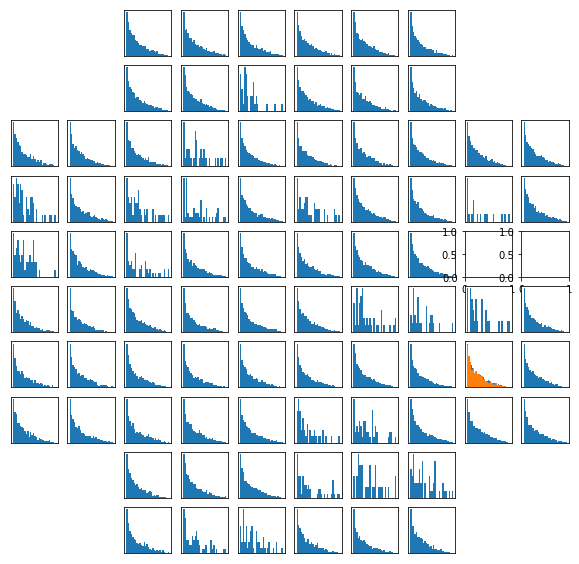

In [254]:
ccd_hist('i_epoch', 'i_epoch')

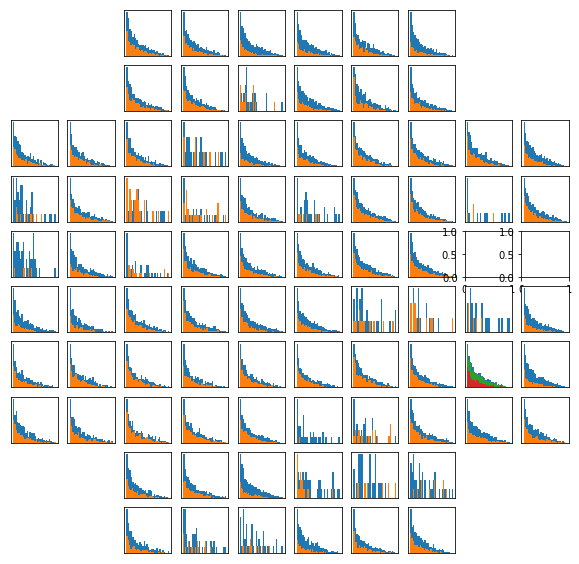

In [258]:
ccd_binhist('i_epoch', 'i_epoch')

### Number of Transit

In [10]:
df['N_Transit'].describe()

count    146294.000000
mean         17.726244
std          80.199694
min           0.000000
25%           3.040500
50%           5.002200
75%          10.080700
max        2760.333100
Name: N_Transit, dtype: float64

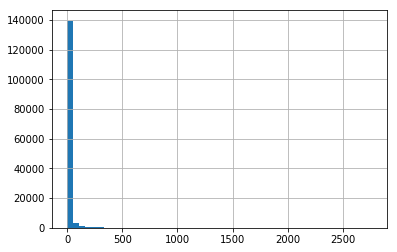

In [11]:
df['N_Transit'].hist(bins=50)
plt.show()

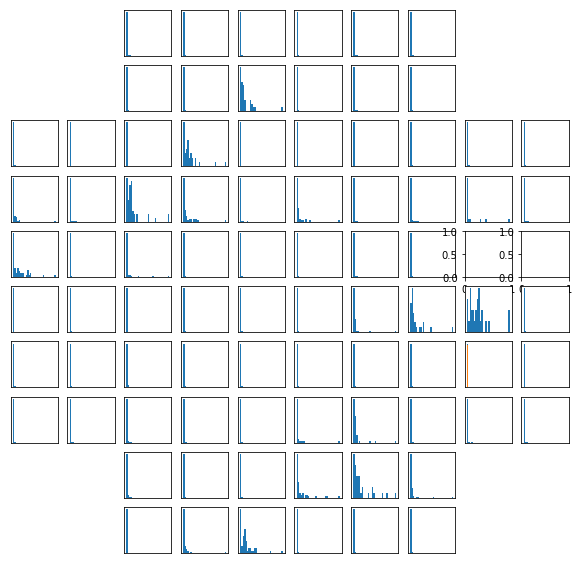

In [259]:
ccd_hist('N_Transit', 'N_Transit')

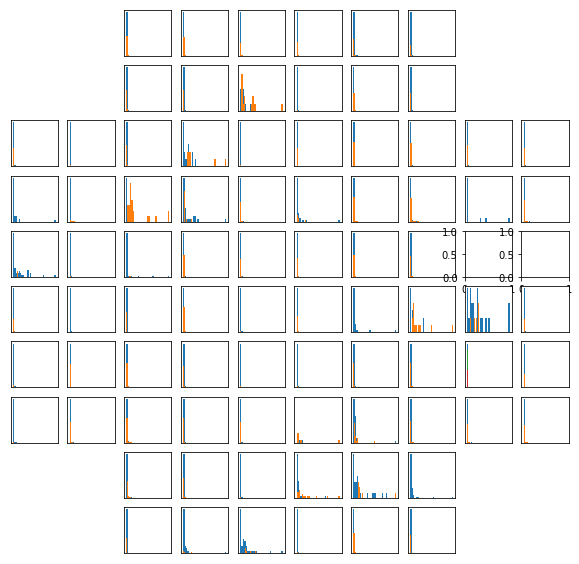

In [260]:
ccd_binhist('N_Transit', 'N_Transit')

### Input Depth

In [12]:
df['i_depth'].describe()

count    146294.000000
mean        721.151558
std        4200.519996
min           0.000000
25%         234.000000
50%         432.000000
75%         770.000000
max      923056.000000
Name: i_depth, dtype: float64

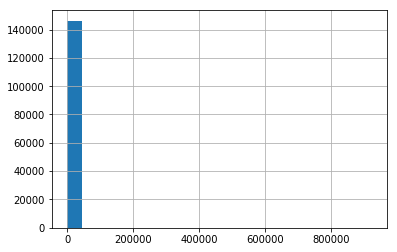

In [13]:
df['i_depth'].hist(bins=20)
plt.show()

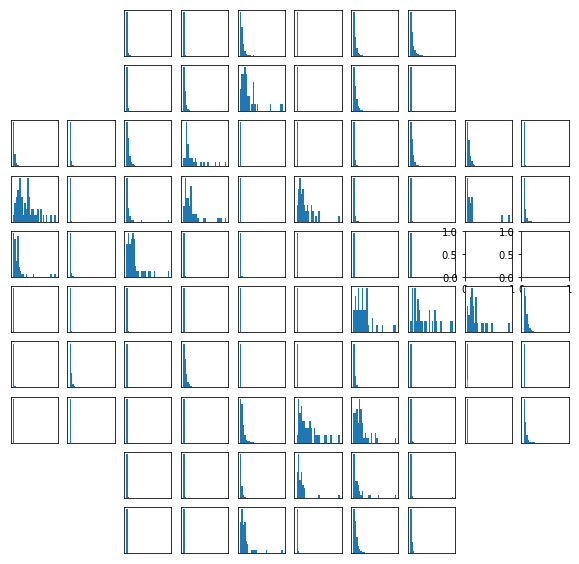

In [261]:
ccd_hist('i_depth', 'i_depth')

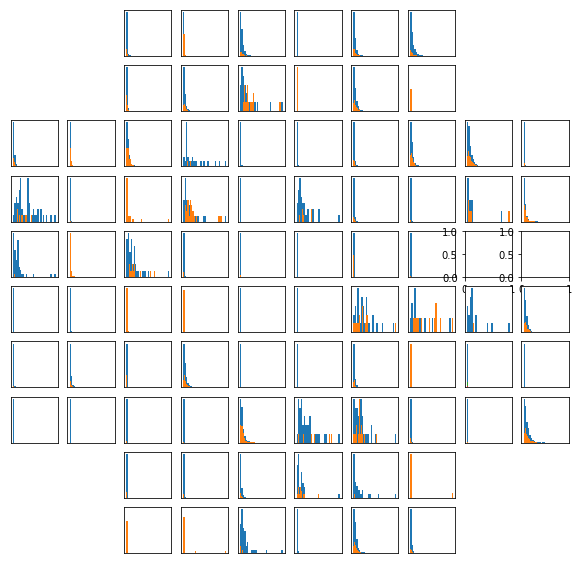

In [262]:
ccd_binhist('i_depth', 'i_depth')

### Input Duration

In [14]:
df['i_dur'].describe()

count    146294.000000
mean         27.579884
std         109.667362
min           0.217420
25%           6.389128
50%           9.548950
75%          13.629950
max        3142.898300
Name: i_dur, dtype: float64

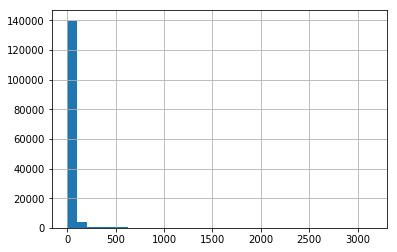

In [15]:
df['i_dur'].hist(bins=30)
plt.show()

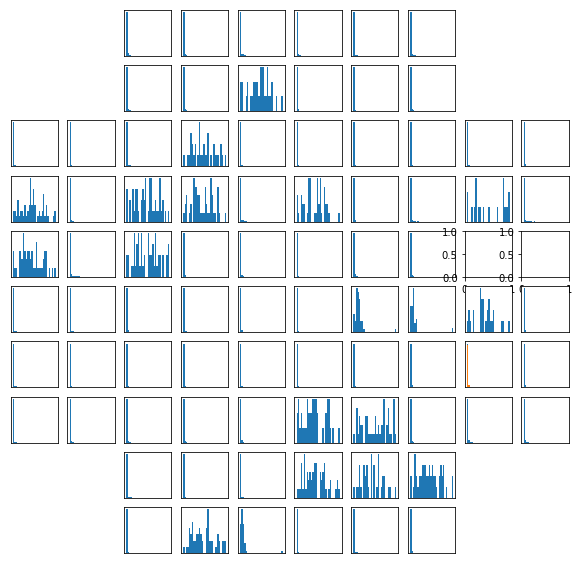

In [263]:
ccd_hist('i_dur', 'i_dur')

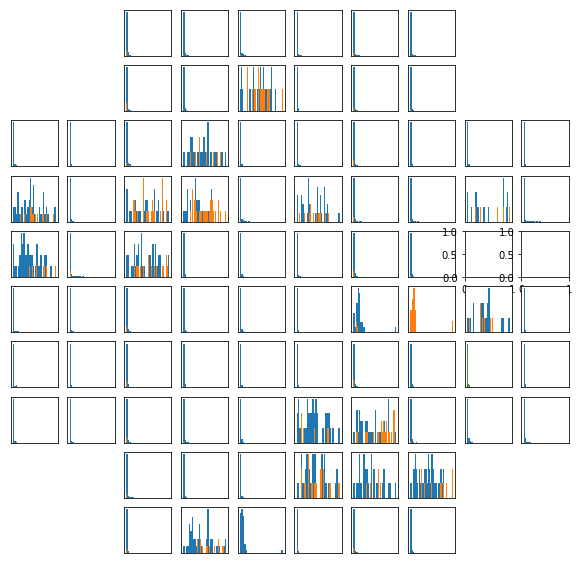

In [264]:
ccd_binhist('i_dur', 'i_dur')

### Impact of Parameter

In [16]:
df['i_b'].describe()

count    146294.000000
mean          0.499279
std           0.288493
min           0.000000
25%           0.249600
50%           0.500400
75%           0.748500
max           1.000000
Name: i_b, dtype: float64

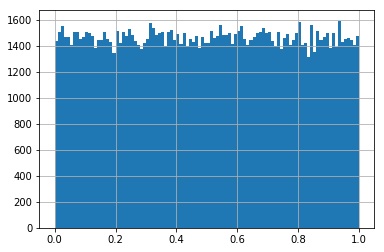

In [17]:
df['i_b'].hist(bins=100)
plt.show()

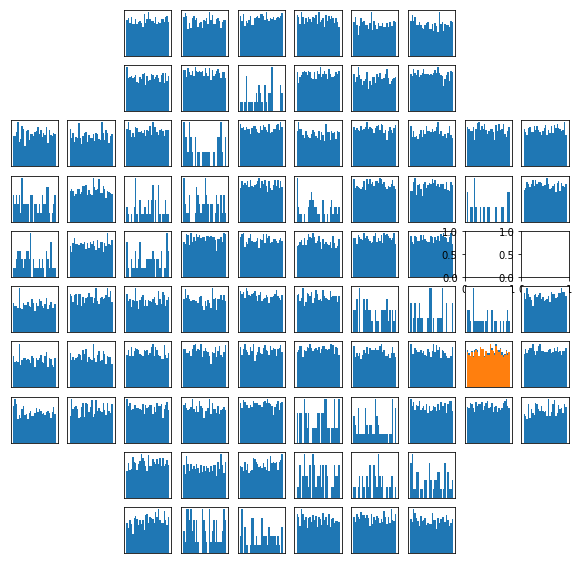

In [265]:
ccd_hist('i_b', 'i_b')

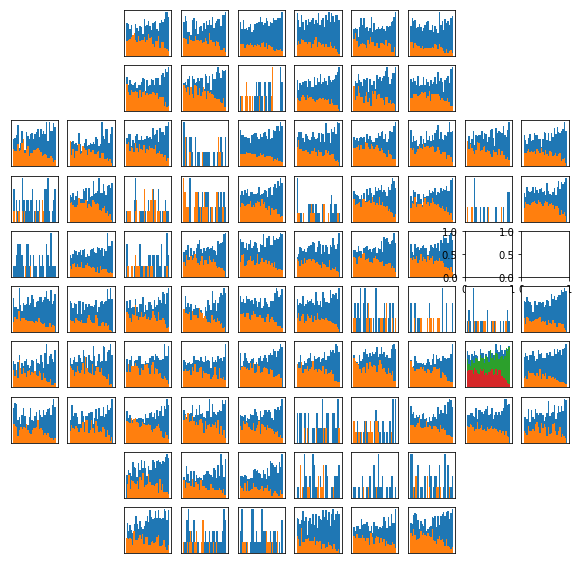

In [266]:
ccd_binhist('i_b', 'i_b')

### Input Ratio

In [18]:
df['i_ror'].describe()

count    146294.000000
mean          0.020701
std           0.039459
min           0.000000
25%           0.013700
50%           0.018300
75%           0.024100
max          11.365500
Name: i_ror, dtype: float64

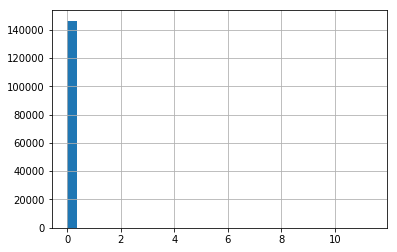

In [19]:
df['i_ror'].hist(bins=30)
plt.show()

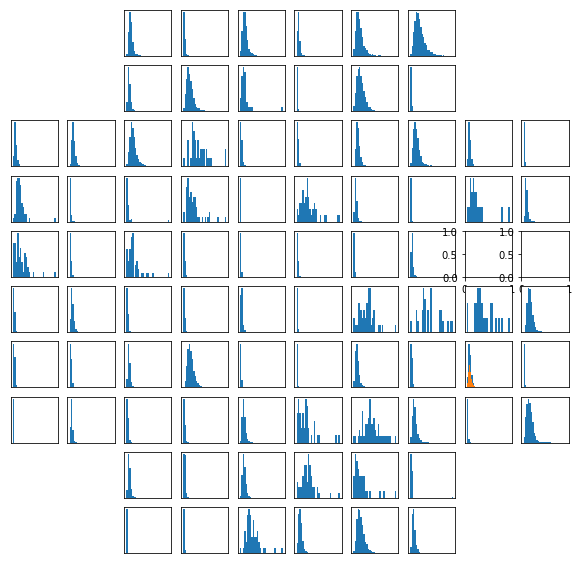

In [267]:
ccd_hist('i_ror', 'i_ror')

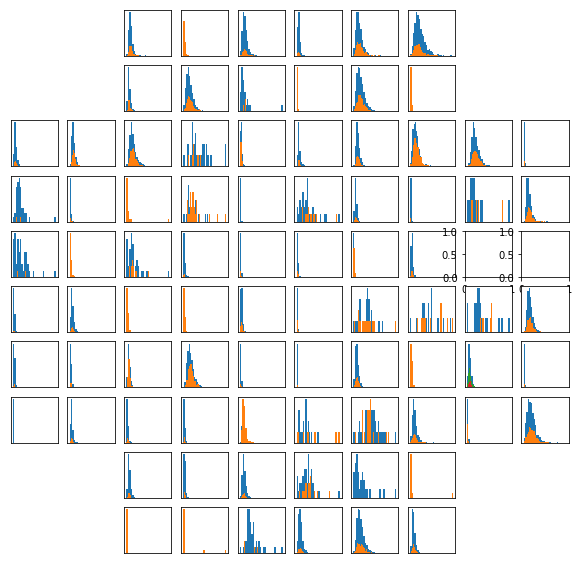

In [268]:
ccd_binhist('i_ror', 'i_ror')

### Semi-Major Axis Ratio

In [20]:
df['i_dor'].describe()

count    146294.000000
mean        138.186792
std          87.984078
min           0.026000
25%          63.765000
50%         132.313000
75%         207.584750
max         487.582000
Name: i_dor, dtype: float64

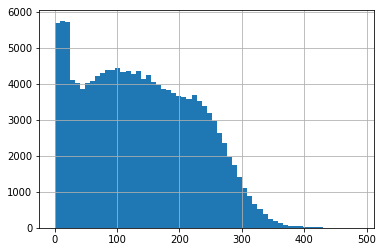

In [21]:
df['i_dor'].hist(bins=60)
plt.show()

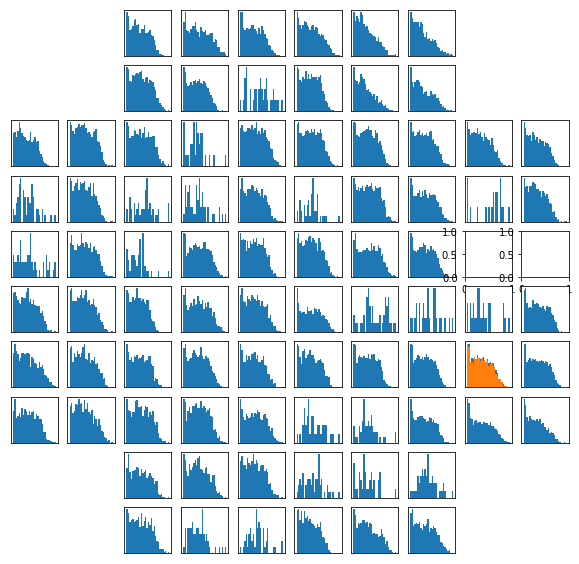

In [269]:
ccd_hist('i_dor', 'i_dor')

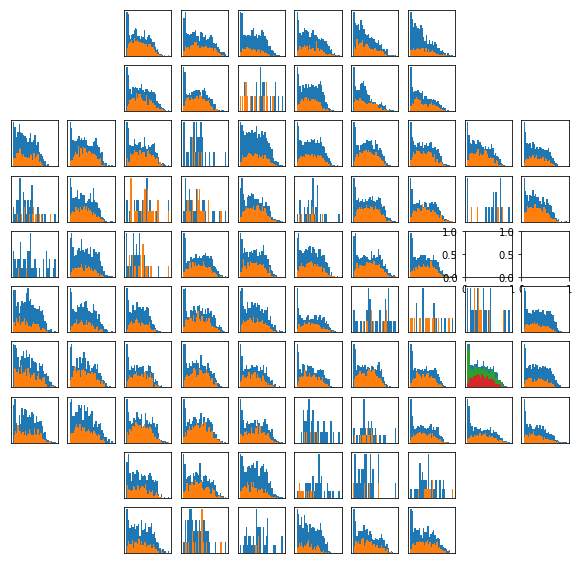

In [270]:
ccd_binhist('i_dor', 'i_dor')

### Expected MES

In [22]:
df['Expected_MES'].describe()

count    146257.000000
mean          8.365588
std           6.381079
min           0.000000
25%           4.918000
50%           7.314200
75%          10.515100
max         282.868800
Name: Expected_MES, dtype: float64

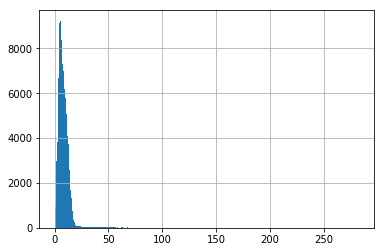

In [23]:
df['Expected_MES'].hist(bins=500)
plt.show()

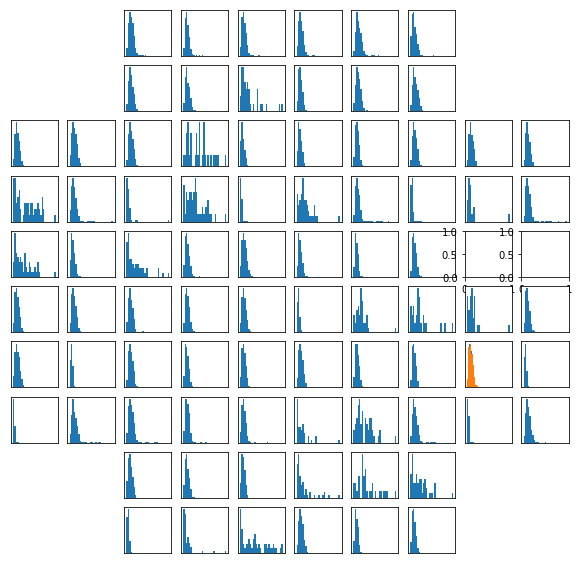

In [273]:
ccd_hist('Expected_MES', 'Expected_MES')

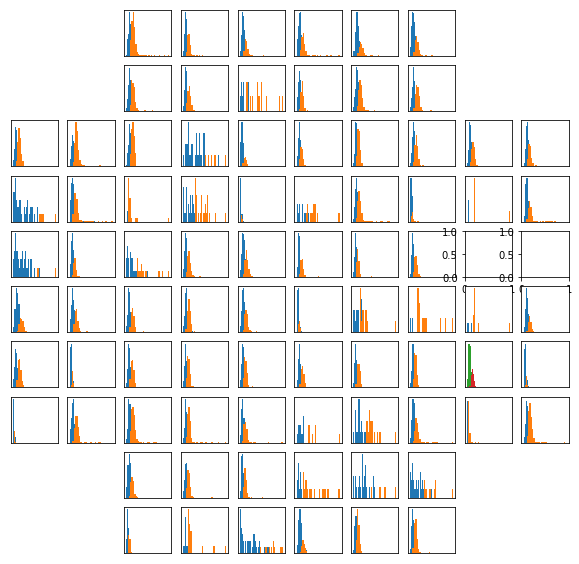

In [274]:
ccd_binhist('Expected_MES', 'Expected_MES')

### Learn Gamma Distribution Parameters
In this section, we aim to learn the parameters of the Gamma CDF function. Although the model has provided the parameters for the data, we also attempt to reproduce the given parameters.

In [24]:
# Gamma Distribution Function Fitter
exp_mes = df['Expected_MES'].values[~np.isnan(df['Expected_MES'].values)]
shape, loc, scale = gamma.fit(exp_mes)

print(shape, loc, scale)

0.0498630668989 -1.87930660979e-26 3.08179479068


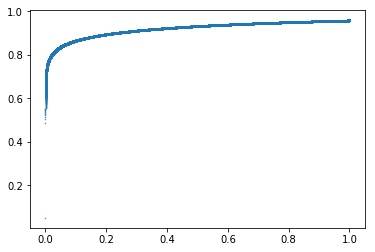

In [67]:
# Learned Parameters
test_mes = np.arange(0.0, 1, 0.000001)
gamma_model = gamma.cdf(test_mes, a=shape, loc=loc, scale=scale)

plt.scatter(test_mes, gamma_model, s=0.2)
plt.show()

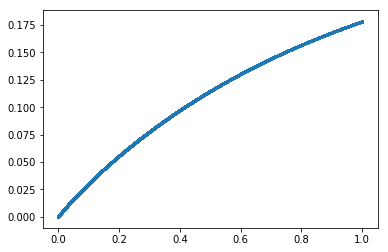

In [51]:
# Default Parameters
test_mes = np.arange(0.0, 1, 0.000001)
gamma_model = 0.271 * gamma.cdf(test_mes, a=0.94)

plt.scatter(test_mes, gamma_model, s=0.2)
plt.show()

### Recovered (Target)

In [26]:
df['Recovered'].describe()

count    146294.000000
mean          0.314182
std           0.472742
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           2.000000
Name: Recovered, dtype: float64

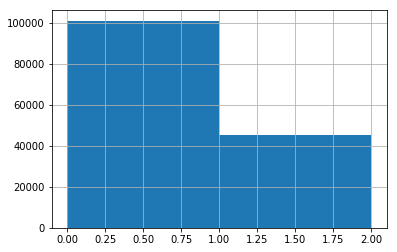

In [27]:
df['Recovered'].hist(bins=2)
plt.show()

#### Per CCD Channel Recovered Matrix

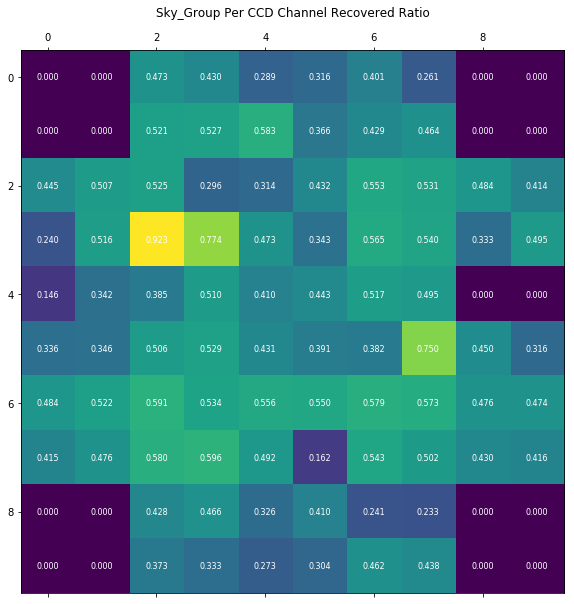

In [169]:
rec_mat = [[0 for i in range(10)] for j in range(10)]

rec_ratio = {}
for x in df[df['Recovered'] != 2].groupby(['Sky_Group', 'Recovered']):
    if x[0][0] not in rec_ratio: rec_ratio[x[0][0]] = {}
    rec_ratio[x[0][0]][x[0][1]] = len(x[1])

for idx in rec_ratio:
    cord = cord_map[idx]
    ratio = rec_ratio[idx][1] / rec_ratio[idx][0]
    # print(idx, cord, ratio)
    rec_mat[cord[0]][cord[1]] = ratio

fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.array(rec_mat))

for (i, j), z in np.ndenumerate(np.array(rec_mat)):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center', fontsize=8, color='w')
plt.title('Sky_Group Per CCD Channel Recovered Ratio')
plt.show()